In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pi = pd.read_csv("/content/drive/MyDrive/SystemC_Pi_Comparison/perf_log.csv")
sc = pd.read_csv("/content/drive/MyDrive/SystemC_Pi_Comparison/latency_sc.csv")

print("Frames Pi:", len(pi))
print("Frames SystemC:", len(sc))


Frames Pi: 311
Frames SystemC: 78


In [2]:
N = len(sc)
pi_cut = pi.head(N).copy()

print("Frames Pi (cut):", len(pi_cut))



Frames Pi (cut): 78


In [6]:
def infer_time_unit_and_to_seconds(df, name="df"):
    """
    Detect whether timestamps are in seconds or milliseconds (or microseconds),
    then convert t_* columns to seconds for consistent calculations.
    """
    df = df.copy()
    tcols = ['t_cam','t_pp','t_det_s','t_det_e','t_dec','t_aud']

    # pick a robust delta proxy: pp - cam (ignore zeros/nans)
    d = (pd.to_numeric(df['t_pp'], errors='coerce') - pd.to_numeric(df['t_cam'], errors='coerce')).dropna()
    d = d[np.isfinite(d)]
    d = d[(d != 0)]

    if len(d) == 0:
        print(f"[{name}] cannot infer time unit (no deltas). Assume seconds.")
        return df, "seconds"

    med = float(np.median(d))

    # Heuristic:
    # - if median delta ~0.005..0.5 => seconds (5ms..500ms)
    # - if median delta ~5..500 => milliseconds (5ms..500ms)
    # - if median delta ~5000..500000 => microseconds (5ms..500ms)
    if 0.001 <= med <= 1.0:
        unit = "seconds"
        scale = 1.0
    elif 1.0 < med <= 1000.0:
        unit = "milliseconds"
        scale = 1.0 / 1000.0
    elif 1000.0 < med <= 1e6:
        unit = "microseconds"
        scale = 1.0 / 1e6
    else:
        # fallback: choose milliseconds as most likely
        unit = "milliseconds(?)"
        scale = 1.0 / 1000.0

    for c in tcols:
        df[c] = pd.to_numeric(df[c], errors='coerce') * scale

    print(f"[{name}] inferred unit = {unit}, median(pp-cam) raw = {med}")
    return df, unit


# Apply conversion
pi = infer_time_unit_and_to_seconds(pi, "Pi")[0]
sc = infer_time_unit_and_to_seconds(sc, "SystemC")[0]

# Re-cut after conversion (optional, keep your style)
N = len(sc)
pi_cut = pi.head(N).copy()


[Pi] inferred unit = seconds, median(pp-cam) raw = 0.009999999999990905
[SystemC] inferred unit = seconds, median(pp-cam) raw = 0.027000000000000024


In [11]:
# =========================
# Compare perf_log (Pi) vs latency_sc (SystemC)
# using pi_cut (same length as sc)
# =========================

from IPython.display import display

REQ_COLS = ['frame_id','t_cam','t_pp','t_det_s','t_det_e','t_dec','t_aud','ran_infer']

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    low = {c.lower().strip(): c for c in df.columns}
    for c in REQ_COLS:
        if c not in df.columns and c in low:
            df = df.rename(columns={low[c]: c})
    return df

def ensure_cols(df: pd.DataFrame, cols=REQ_COLS):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise ValueError(f"Missing columns: {miss}\nFound: {list(df.columns)}")

def to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    df = normalize_cols(df)
    ensure_cols(df)
    df = df[REQ_COLS].copy()
    for c in REQ_COLS:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=['frame_id','t_cam']).copy()
    df['frame_id'] = df['frame_id'].astype(int)
    df['ran_infer'] = df['ran_infer'].fillna(0).astype(int)
    # replace NaN t_aud with 0 (meaning "not marked")
    df['t_aud'] = df['t_aud'].fillna(0.0)
    return df

def add_metrics(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = df.sort_values('t_cam').reset_index(drop=True).copy()

    # Stage durations (ms)
    df['pp_ms'] = (df['t_pp'] - df['t_cam']) * 1000.0

    det_valid = (df['ran_infer'] == 1) & (df['t_det_s'] > 0) & (df['t_det_e'] > 0)
    df['det_ms'] = np.where(det_valid, (df['t_det_e'] - df['t_det_s']) * 1000.0, np.nan)
    df['e2e_det_ms'] = np.where(det_valid, (df['t_det_e'] - df['t_cam']) * 1000.0, np.nan)

    df['dec_after_det_ms'] = np.where(det_valid, (df['t_dec'] - df['t_det_e']) * 1000.0, np.nan)
    df['dec_after_pp_ms']  = (df['t_dec'] - df['t_pp']) * 1000.0

    aud_valid = df['t_aud'] > 0
    df['aud_delay_ms'] = np.where(aud_valid, (df['t_aud'] - df['t_dec']) * 1000.0, np.nan)

    # FPS estimates from logged rows (these are "detector-loop rows", not every camera frame)
    dt = df['t_cam'].diff()
    df['dt_cam_s'] = dt
    df['det_loop_fps_inst'] = (1.0 / dt).replace([np.inf, -np.inf], np.nan)

    d_id = df['frame_id'].diff()
    df['cam_fps_est_inst'] = (d_id / dt).replace([np.inf, -np.inf], np.nan)

    df['source'] = label
    return df

def summarize(series: pd.Series) -> dict:
    s = series.dropna().astype(float)
    if len(s) == 0:
        return {'count': 0, 'mean': np.nan, 'median': np.nan, 'p95': np.nan, 'p99': np.nan, 'min': np.nan, 'max': np.nan}
    return {
        'count': int(s.count()),
        'mean': float(s.mean()),
        'median': float(s.median()),
        'p95': float(np.percentile(s, 95)),
        'p99': float(np.percentile(s, 99)),
        'min': float(s.min()),
        'max': float(s.max()),
    }

def summarize_df(df: pd.DataFrame, label: str) -> pd.DataFrame:
    rows = []
    for metric in ['pp_ms','det_ms','e2e_det_ms','dec_after_det_ms','dec_after_pp_ms','aud_delay_ms']:
        stat = summarize(df[metric])
        stat['metric'] = metric
        stat['source'] = label
        rows.append(stat)
    return pd.DataFrame(rows)

def fps_summary(df: pd.DataFrame) -> dict:
    det_loop_fps = df['det_loop_fps_inst'].dropna()
    cam_fps_est  = df['cam_fps_est_inst'].dropna()
    return {
        'det_loop_fps_median': float(det_loop_fps.median()) if len(det_loop_fps) else np.nan,
        'det_loop_fps_mean': float(det_loop_fps.mean()) if len(det_loop_fps) else np.nan,
        'cam_fps_est_median': float(cam_fps_est.median()) if len(cam_fps_est) else np.nan,
        'cam_fps_est_mean': float(cam_fps_est.mean()) if len(cam_fps_est) else np.nan,
        'rows': int(len(df)),
        'ran_infer_rate': float((df['ran_infer'] == 1).mean()),
        'audio_mark_rate': float((df['t_aud'] > 0).mean()),
    }

def plot_hist(a: pd.DataFrame, b: pd.DataFrame, metric: str, bins=40, xlim=None):
    plt.figure()
    plt.hist(a[metric].dropna(), bins=bins, alpha=0.6, label=a['source'].iloc[0])
    plt.hist(b[metric].dropna(), bins=bins, alpha=0.6, label=b['source'].iloc[0])
    plt.xlabel(metric)
    plt.ylabel("count")
    plt.title(f"Histogram: {metric}")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.legend()
    plt.show()

# ---- Prepare dfs ----
pi_cut = to_numeric_df(pi_cut)
sc     = to_numeric_df(sc)

pi_m = add_metrics(pi_cut, "pi_perf_log_cut")
sc_m = add_metrics(sc,     "systemc_latency")

print("After normalize:", "Pi_cut rows =", len(pi_m), ", SystemC rows =", len(sc_m))




After normalize: Pi_cut rows = 78 , SystemC rows = 78



=== Latency summary (ms) ===


,count,mean,median,p95,p99,min,max,metric,source
0,78,8.205128,10.000,10.0000,20.0000,0.0,20.00,pp_ms,pi_perf_log_cut
1,78,190.256410,180.000,284.5000,342.3000,130.0,350.00,det_ms,pi_perf_log_cut
2,78,198.461538,185.000,294.5000,354.6000,130.0,370.00,e2e_det_ms,pi_perf_log_cut
3,78,0.384615,0.000,0.0000,10.0000,0.0,10.00,dec_after_det_ms,pi_perf_log_cut
4,78,190.641026,180.000,284.5000,342.3000,130.0,350.00,dec_after_pp_ms,pi_perf_log_cut
5,31,0.000000,0.000,0.0000,0.0000,0.0,0.00,aud_delay_ms,pi_perf_log_cut
6,78,27.395538,27.000,42.1005,48.6382,10.0,50.44,pp_ms,systemc_latency
7,78,178.397436,170.000,265.0000,284.5500,170.0,350.00,det_ms,systemc_latency
8,78,205.792974,198.945,277.3695,333.0419,180.0,391.97,e2e_det_ms,systemc_latency
9,78,1.282051,0.000,10.0000,10.0000,0.0,10.00,dec_after_det_ms,systemc_latency



=== FPS summary ===


,source,det_loop_fps_median,det_loop_fps_mean,cam_fps_est_median,cam_fps_est_mean,rows,ran_infer_rate,audio_mark_rate
0,pi_perf_log_cut,5.263158,5.297359,30.000000,30.055970,78,1.0,0.397436
1,systemc_latency,5.086987,5.372149,30.043563,30.044995,78,1.0,0.256410


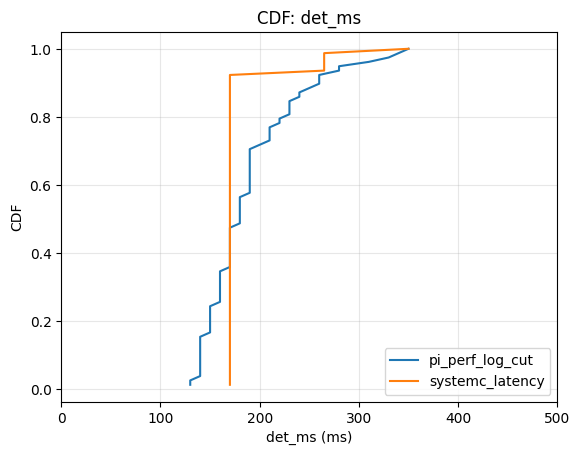

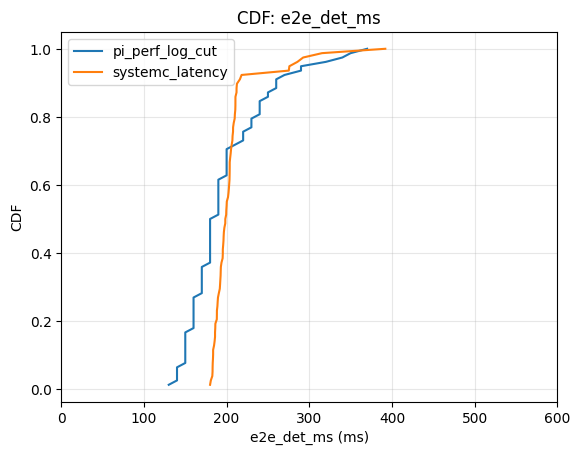

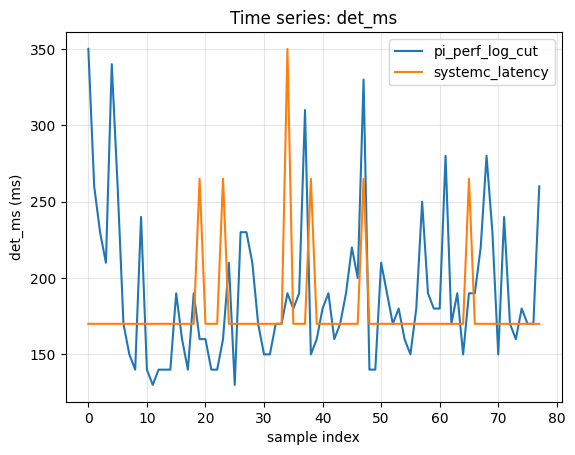


Saved: comparison_summary.csv, comparison_fps.csv


In [12]:
# ---- Summary tables ----
summary = pd.concat([
    summarize_df(pi_m, "pi_perf_log_cut"),
    summarize_df(sc_m, "systemc_latency"),
], ignore_index=True)

fps = pd.DataFrame([
    {'source': 'pi_perf_log_cut', **fps_summary(pi_m)},
    {'source': 'systemc_latency', **fps_summary(sc_m)},
])

print("\n=== Latency summary (ms) ===")
display(summary)

print("\n=== FPS summary ===")
display(fps)

def plot_cdf(a, b, metric, xlim=None):
    plt.figure()
    for df, label in [(a, a['source'].iloc[0]), (b, b['source'].iloc[0])]:
        x = df[metric].dropna().values
        x = np.sort(x)
        y = np.arange(1, len(x)+1) / len(x)
        plt.plot(x, y, label=label)
    plt.xlabel(metric + " (ms)")
    plt.ylabel("CDF")
    plt.title("CDF: " + metric)
    if xlim: plt.xlim(*xlim)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_timeseries(a, b, metric, max_points=300):
    plt.figure()
    a_y = a[metric].dropna().values[:max_points]
    b_y = b[metric].dropna().values[:max_points]
    plt.plot(a_y, label=a['source'].iloc[0])
    plt.plot(b_y, label=b['source'].iloc[0])
    plt.xlabel("sample index")
    plt.ylabel(metric + " (ms)")
    plt.title("Time series: " + metric)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 1) Inference latency distribution (most important)
plot_cdf(pi_m, sc_m, "det_ms", xlim=(0, 500))

# 2) End-to-end to detection end
plot_cdf(pi_m, sc_m, "e2e_det_ms", xlim=(0, 600))

# 3) Spike behavior over time
plot_timeseries(pi_m, sc_m, "det_ms", max_points=200)

# ---- Optional: save comparison CSVs ----
summary.to_csv("comparison_summary.csv", index=False)
fps.to_csv("comparison_fps.csv", index=False)
print("\nSaved: comparison_summary.csv, comparison_fps.csv")

/tmp/ipython-input-3209326282.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  camfps = d.groupby('sec').apply(camfps).rename(f'{name}_CamFPS_est')
/tmp/ipython-input-3209326282.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  camfps = d.groupby('sec').apply(camfps).rename(f'{name}_CamFPS_est')


,sec,Pi_DetFPS,Pi_CamFPS_est,SystemC_DetFPS,SystemC_CamFPS_est
0,0,4,27.586207,6.0,29.785084
1,1,4,29.629630,6.0,30.107047
2,2,6,29.411765,5.0,29.960507
3,3,6,29.885057,5.0,30.067536
4,4,6,30.232558,5.0,30.049160
5,5,5,29.545455,6.0,30.077198
6,6,5,28.985507,4.0,29.963363
7,7,5,29.069767,5.0,30.056386
8,8,5,31.506849,5.0,30.231408
9,9,5,33.333333,5.0,30.216227


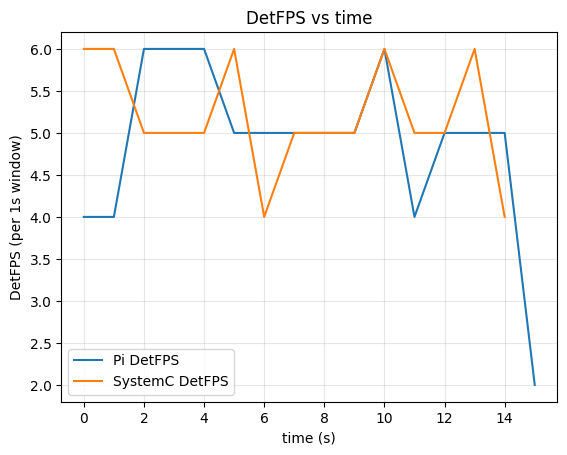

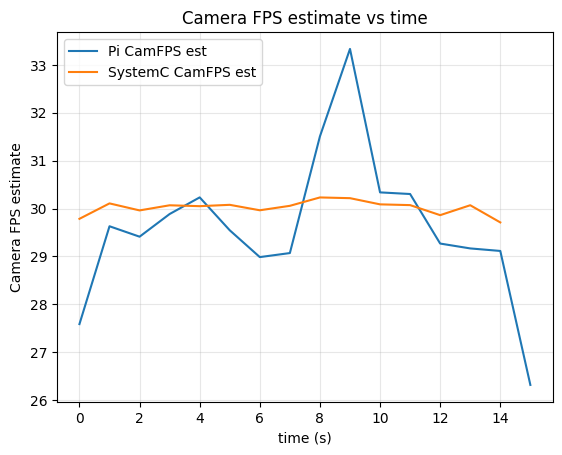

In [9]:
def fps_per_second(df, name):
    d = df.sort_values('t_cam').copy()
    t0 = d['t_cam'].min()
    d['sec'] = np.floor(d['t_cam'] - t0).astype(int)

    # DetFPS: count of ran_infer==1 per second (matches your C++ "DetFPS")
    detfps = d.groupby('sec')['ran_infer'].sum().rename(f'{name}_DetFPS')

    # CameraFPS estimate: within each second, estimate from frame_id span / time span
    def camfps(g):
        if len(g) < 2:
            return np.nan
        dt = g['t_cam'].iloc[-1] - g['t_cam'].iloc[0]
        if dt <= 0:
            return np.nan
        did = g['frame_id'].iloc[-1] - g['frame_id'].iloc[0]
        return did / dt
    camfps = d.groupby('sec').apply(camfps).rename(f'{name}_CamFPS_est')

    out = pd.concat([detfps, camfps], axis=1).reset_index()
    return out

fps_pi = fps_per_second(pi_m, 'Pi')
fps_sc = fps_per_second(sc_m, 'SystemC')

# Merge on seconds
fps_merge = pd.merge(fps_pi, fps_sc, on='sec', how='outer').sort_values('sec')
display(fps_merge.head(20))

# Plot: DetFPS
plt.figure()
plt.plot(fps_merge['sec'], fps_merge['Pi_DetFPS'], label='Pi DetFPS')
plt.plot(fps_merge['sec'], fps_merge['SystemC_DetFPS'], label='SystemC DetFPS')
plt.xlabel('time (s)')
plt.ylabel('DetFPS (per 1s window)')
plt.title('DetFPS vs time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot: Camera FPS estimate
plt.figure()
plt.plot(fps_merge['sec'], fps_merge['Pi_CamFPS_est'], label='Pi CamFPS est')
plt.plot(fps_merge['sec'], fps_merge['SystemC_CamFPS_est'], label='SystemC CamFPS est')
plt.xlabel('time (s)')
plt.ylabel('Camera FPS estimate')
plt.title('Camera FPS estimate vs time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
